<a href="https://colab.research.google.com/github/johntanas/it1244project/blob/main/code/model_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score,average_precision_score,SCORERS

Running this file might take a while (>1 hour) due to KNN and n_repeats=5

In [ ]:
n_repeats=5
n_splits=5

In [2]:
path_to_max_label="/content/max_label.csv"
path_to_app="/content/cleaned_application.csv"
cleaned_app_df=pd.read_csv(path_to_app,index_col=0)
max_df=pd.read_csv(path_to_max_label,index_col=0)

In [3]:
dep_var="status"
random_state=42

Sort by median income of job to give a ordering to the jobs

In [4]:
order=cleaned_app_df.groupby("job")["income"].median().sort_values()

In [5]:
cleaned_app_df["job"]=cleaned_app_df["job"].replace(order)

In [6]:
train_df=max_df.merge(cleaned_app_df,how="inner",on="id").drop("id",axis=1)

In [7]:
numerical_transformer = StandardScaler()
categorical_transformer=OneHotEncoder()
ord_transformer=OrdinalEncoder()

In [8]:
X,y=train_df.drop(columns=dep_var),train_df[dep_var]

In [9]:
categorical_cols = [cname for cname in X.columns if X[cname].nunique() < 10 and 
                        X[cname].dtype == "object"]
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]


In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('ord',ord_transformer,['job'])
    ])

In [11]:
xs=preprocessor.fit_transform(X)

In [12]:
score_df=pd.DataFrame()

We will be doing cross validation with StratifiedKFold =5 and 5 repeats.
We use StratifiedKFold instead of Kfold to perserve  the percentage of samples for each class.

In [14]:
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

In [15]:
# dataframe of scores to be converted into plot later
score_df=pd.DataFrame()


* AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen. 
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
* Thus we choose AUC as the banks who use the models can determine their own threshold risk probability for bad users and calculate their expected value/loss for these bad users and give them an appropriate interest rate when extending credit to them


There is very little linearity in the imbalanced dataset for the linear dividing line of logisitic regression to work on. This can be seen from the low level of correlation in the table below where all variables have correlation between -0.03 and 0.03 and logisitic regression will be similar to random guessing so we do not try logisitic regression

(array([0.5]), <a list of 1 Text major ticklabel objects>)

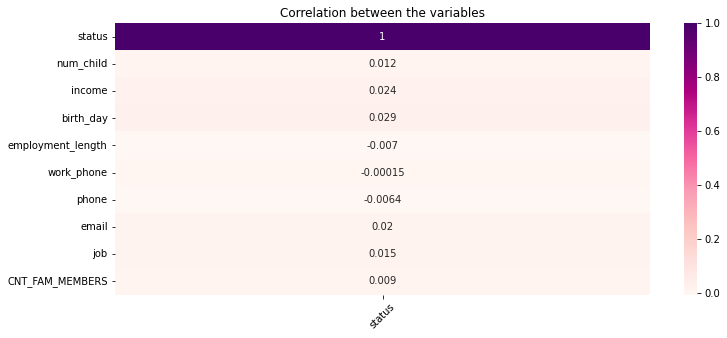

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(12,5))
status_correlation=train_df.corr()[["status"]]
sns.heatmap(status_correlation,annot=True,cmap='RdPu')
plt.title('Correlation between the variables')
plt.xticks(rotation=45)

We cannot choose k= sqrt(len(X_train)) as it would be very hard to detect the minority class

In [17]:
# try different K values
bestscore=0
bestmodel=None
for i in range(1,8,2):
    scores=[]
    for train_index, test_index in cv.split(xs,y):
          X_train = xs[train_index]
          y_train = y[train_index]
          X_test = xs[test_index]
          y_test = y[test_index]
          model = KNeighborsClassifier(i)
          model.fit(X_train, y_train)  
          y_pred = model.predict(X_test)
          score=roc_auc_score(y_test,y_pred)
          if score>bestscore:
              bestmodel=model
              bestscore=score
              print(f"KNN {i} with best score of {score}")
          scores.append(roc_auc_score(y_test,y_pred))
    score_df["KNN"+str(i)]=scores
    print(f"KNN {i} with avg score of {np.array(scores).mean()}")

KNN 1 with best score of 0.6394437007810607
KNN 1 with best score of 0.6535287839297788
KNN 1 with best score of 0.6561257929593076
KNN 1 with best score of 0.6593533198924998


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-64ac426c237d>", line 13, in <module>
    y_pred = model.predict(X_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py", line 214, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py", line 759, in kneighbors
    **kwds,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py", line 1726, in pairwise_distances_chunked
    D_chunk = reduce_func(D_chunk, sl.start)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py", line 640, in _kneighbors_reduce_func
    result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most

KeyboardInterrupt: ignored

Knn with small K (1) is more able to detect the minority class in a imbalanced dataset. However, this would make this model more prone to noise

In [18]:
bestscore=0
bestmodel=None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      model = DecisionTreeClassifier(random_state=random_state)
      model.fit(X_train, y_train )  
      y_pred = model.predict(X_test)
      score=roc_auc_score(y_test,y_pred)
      if score>bestscore:
          bestmodel=model
          bestscore=score
          print(f"DecisionTreeClassifier with best score of {score}")
      scores.append(roc_auc_score(y_test,y_pred))
score_df["DecisionTreeClassifier"]=scores
print(f"DecisionTreeClassifier with avg score of {np.array(scores).mean()}")

DecisionTreeClassifier with best score of 0.6154507996547922
DecisionTreeClassifier with best score of 0.633213486337515
DecisionTreeClassifier with best score of 0.6367066919297606
DecisionTreeClassifier with best score of 0.6435055695120984
DecisionTreeClassifier with best score of 0.6458358471416143


In [19]:
bestscore=0
bestmodel=None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      model = RandomForestClassifier(random_state=random_state,class_weight ="balanced_subsample")
      model.fit(X_train, y_train )  
      y_pred = model.predict(X_test)
      score=roc_auc_score(y_test,y_pred)
      if score>bestscore:
          bestmodel=model
          bestscore=score
          print(f"RandomForestClassifier with best score of {score}")
      scores.append(roc_auc_score(y_test,y_pred))
score_df["RandomForestClassifier"]=scores
print(f"RandomForestClassifier with avg score of {np.array(scores).mean()}")

RandomForestClassifier with best score of 0.6973125149408781
RandomForestClassifier with best score of 0.710899999528944
RandomForestClassifier with best score of 0.7144292191003642


Random forests are an ensemble of decision trees and typically do better than decision trees

In [21]:
import keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [24]:
bestscore=0
bestmodel=None
bestmodel_val_data=None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      model= keras.Sequential([
      keras.layers.Dense(512,activation="sigmoid"),
      keras.layers.Dense(256,activation="relu"),
      keras.layers.Dense(128,activation="relu"),
      keras.layers.Dense(2,activation="sigmoid")])
      #Adam > SGD
      opt = tf.optimizers.Adam(learning_rate=0.01)
      #Use BinaryFocalCrossentropy instead of BinaryCrossentropy
      model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), optimizer=opt, metrics=[tf.keras.metrics.AUC(curve='ROC')])
      history=model.fit(X_train, pd.get_dummies(y_train),batch_size=64, epochs=10,validation_data=(X_test,pd.get_dummies(y_test)),verbose=0)
      y_pred = model.predict(X_test,verbose=0)
      score=roc_auc_score(y_test,y_pred[:,1])
      if score>bestscore:
          bestmodel=model
          bestmodel_val_data=[y_test,X_test]
          bestscore=score
          print(f"NN with best score of {score}")
      scores.append(score)
score_df["NN"]=scores
print(f"NN with avg score of {np.array(scores).mean()}")

NN with best score of 0.5772146385044953
NN with best score of 0.5833442944433151
NN with avg score of 0.5605707167835327


In [25]:
y_test,X_test=bestmodel_val_data[0],bestmodel_val_data[1]
preds=bestmodel.predict(X_test)

228/228 [==============================] - 1s 2ms/step


In [26]:
bestmodel.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               19456     
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dense_27 (Dense)            (None, 2)                 258       
                                                                 
Total params: 183,938
Trainable params: 183,938
Non-trainable params: 0
_________________________________________________________________


In [27]:
preds.min(axis=0),preds.max(axis=0)

(array([0.5752733 , 0.19538252], dtype=float32),
 array([0.8025779 , 0.42121083], dtype=float32))

While deep neural networks should be resilient to noisy data https://arxiv.org/pdf/1705.10694.pdf, our dataset which is noisy (we will be giving this assertion a basis later in this notebook) is not large (n~36000) and  our neural network deep. If we had more computing power (10^8 operations/s on our cpus), we could try to train a model with >10^12 params.

In [28]:
score_df.to_csv("score_no_aug.csv")

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line and it is one method to deal with imbalanced data
https://arxiv.org/abs/1106.1813

In [29]:
# score Dataframe for model with smote 
score_df_smote=pd.DataFrame()

In [30]:
bestscore=0
bestmodel=None
# we stop at k ==11 as it seems that the knn auc roc score drops off at k=7
for i in range(1,12,2):
    scores=[]
    for train_index, test_index in cv.split(xs,y):
        X_train = xs[train_index]
        y_train = y[train_index]
        X_test = xs[test_index]
        y_test = y[test_index]
        sm = SMOTE()
        X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
        model = KNeighborsClassifier(i)
        model.fit(X_train_oversampled, y_train_oversampled)  
        y_pred = model.predict(X_test)
        score=roc_auc_score(y_test,y_pred)
        scores.append(score)
        if score>bestscore:
            bestmodel=model
            bestscore=score
            print(f"KNN {i} with best score of {score}")
    score_df_smote["KNN"+str(i)]=scores
    print(f"KNN {i} with best score of {score}")

KNN 1 with best score of 0.6429638214047293
KNN 1 with best score of 0.6562083134977137
KNN 1 with best score of 0.6631162634971123
KNN 1 with best score of 0.653364952059185
KNN 3 with best score of 0.6640938328069196
KNN 3 with best score of 0.6697184752135785
KNN 3 with best score of 0.6563162988625447
KNN 5 with best score of 0.6823342677734694
KNN 5 with best score of 0.6841606887852808
KNN 5 with best score of 0.691039464706494
KNN 5 with best score of 0.693251163055298
KNN 5 with best score of 0.6983043253445865
KNN 5 with best score of 0.6983043253445865
KNN 7 with best score of 0.6991918129023679
KNN 7 with best score of 0.7014844966422769
KNN 7 with best score of 0.7014844966422769
KNN 9 with best score of 0.6911851297052604
KNN 11 with best score of 0.6921525156019172


Smote works by using a random example from the minority class which is first chosen. Then k of the nearest neighbors for that example are found (k=5 is the default value which is used here). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space. Thus, smote is essentially overfitting our KNN classifier
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [31]:
bestscore=0
bestmodel=None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      sm = SMOTE()
      X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
      model = DecisionTreeClassifier(random_state=random_state)
      model.fit(X_train_oversampled, y_train_oversampled )  
      y_pred = model.predict(X_test)
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore=score
            print(f"DecisionTreeClassifier with best score of {score}")
score_df_smote["DecisionTreeClassifier"]=scores
print(f"DecisionTreeClassifier with avg score of {np.array(scores).mean()}")

DecisionTreeClassifier with best score of 0.6576365100859636
DecisionTreeClassifier with best score of 0.6674370857616118
DecisionTreeClassifier with best score of 0.6686350464914121
DecisionTreeClassifier with best score of 0.6767541490065974
DecisionTreeClassifier with best score of 0.6767935546499203
DecisionTreeClassifier with avg score of 0.6668890643023954


In [32]:
bestscore=0
bestmodel=None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      sm = SMOTE()
      X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
      model = RandomForestClassifier(random_state=random_state)
      model.fit(X_train_oversampled, y_train_oversampled)  
      y_pred = model.predict(X_test)
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore=score
            print(f"RandomForestClassifier with best score of {score}")
score_df_smote["RandomForestClassifier"]=scores
print(f"RandomForestClassifier with avg score of {np.array(scores).mean()}")

RandomForestClassifier with best score of 0.6654020568782147
RandomForestClassifier with best score of 0.6733816126884202
RandomForestClassifier with best score of 0.6740370619587159
RandomForestClassifier with best score of 0.6811453870757462
RandomForestClassifier with best score of 0.6817285000092399
RandomForestClassifier with avg score of 0.6714811633505591


Surpisingly, smote actually deproves auc score across the trees models but improves knn , suggesting that the orginial data is quite noisy, and creating sythenic data will only add on to the noise.

In [33]:
score_df_smote.to_csv("score_smote.csv")

Thus,we could also try totem links on knn and rf.

In [34]:
from imblearn.under_sampling import TomekLinks

In [35]:
#totem link dataframe
score_df_tl=pd.DataFrame()

In [36]:
bestscore=0
bestmodel=None
scores=[]
# we stop at k ==9 as it seems that the knn auc roc score drops off at k=7
for i in range(1,10,2):
    scores=[]
    for train_index, test_index in cv.split(xs,y):
        X_train = xs[train_index]
        y_train = y[train_index]
        X_test = xs[test_index]
        y_test = y[test_index]
        tl = TomekLinks()
        X_train_undersampled, y_train_undersampled = tl.fit_resample(X_train, y_train)
        model = KNeighborsClassifier(i)
        model.fit(X_train_undersampled, y_train_undersampled)  
        y_pred = model.predict(X_test)
        score=roc_auc_score(y_test,y_pred)
        scores.append(score)
        if score>bestscore:
            bestmodel=model
            bestscore=score
            print(f"KNN {i} with best score of {score}")
    score_df_tl["KNN"+str(i)]=scores
    print(f"KNN {i} with best score of {score}")

KNN 1 with best score of 0.6485150870972884
KNN 1 with best score of 0.6575296012660017
KNN 1 with best score of 0.6591939072896635
KNN 1 with best score of 0.6640410231947574
KNN 1 with best score of 0.649792173731238
KNN 3 with best score of 0.6186403368122627
KNN 5 with best score of 0.5879118161490305
KNN 7 with best score of 0.5612235062724726
KNN 9 with best score of 0.5405174259907667


In [37]:
bestscore=0
bestmodel=None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      sm = SMOTE()
      X_train_undersampled, y_train_undersampled = tl.fit_resample(X_train, y_train)
      model = RandomForestClassifier(random_state=random_state)
      model.fit(X_train_undersampled, y_train_undersampled)   
      y_pred = model.predict(X_test)
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore=score
            print(f"RandomForestClassifier with best score of {score}")
score_df_tl["RandomForestClassifier"]=scores
print(f"RandomForestClassifier with avg score of {np.array(scores).mean()}")

RandomForestClassifier with best score of 0.6270542406577551
RandomForestClassifier with best score of 0.6452184744071596
RandomForestClassifier with best score of 0.6533349675351853
RandomForestClassifier with avg score of 0.6395162943725977


In [38]:
score_df_tl.to_csv("score_tl.csv")